In [360]:
import pandas as pd 
import geopandas as gpd
import shapely as shp
import matplotlib 
import matplotlib.pyplot as plt
import os
import osmnx as ox
from shapely.geometry import Point
import pysal


In [412]:
# specify path for the folder of analysis where all the files specified below have to be safed
path = r'C:\Users\Johannes\Documents\Arbeit\World Bank\Urban flooding and firms\City paper\Analyses\Dar es Salaam'

# specify name of employment density shape file
dtainput = r'Firm_TZ_weighted_04December.dta'

# specify area of analysis
place = 'Dar es Salaam'


In [413]:
dta_raw=pd.read_stata(os.path.join(path, dtainput))
dta_raw.head()

,SubmissionDate,region_name,firm_name,gpsLatitude,gpsLongitude,agree,district_name,ward_name,q1_1,q1_2,...,q9_6_2,q9_6_3,q9_6_4,q9_6_5,email,phone,metainstanceID,KEY,strata,weight
0,2018-11-07 08:24:05,Dar Es Salaam,Zenith security,-6.795214,39.214748,Yes,Kinondoni,Mwanzange,Emma stephen,Employee,...,0,0,0,0,Zenith security,6.934458e+08,uuid:001c443c-35a0-440c-beef-d5114f53c621,uuid:001c443c-35a0-440c-beef-d5114f53c621,Communication and Other Services,10.240007
1,2018-10-03 12:57:54,Dar Es Salaam,GASPER JOHN,-6.763073,39.227882,Yes,Kinondoni,Chigongwe,Gasper john,Owner,...,0,0,0,0,,7.545869e+08,uuid:004378cd-904e-4128-912f-87d4d1ccea5e,uuid:004378cd-904e-4128-912f-87d4d1ccea5e,"Manufacturing, Mining, Water, Energy, Agriculture",76.323410
2,2018-10-18 20:00:22,Dar Es Salaam,DOHA AUTO PARTS,-6.864308,39.266754,Yes,Temeke,Kibamba,Martha,Employee,...,9999,9999,9999,9999,0,6.562410e+08,uuid:006eeeb1-8380-42f3-8f6a-142b71dbc2db,uuid:006eeeb1-8380-42f3-8f6a-142b71dbc2db,Wholesale and retail trade; repair of motor ve...,67.432579
3,2018-10-22 16:14:36,Dar Es Salaam,MALOLO LODGE,-6.866735,39.258389,Yes,Temeke,Kibamba,Mariam,Employee,...,0,0,0,0,,1.000000e+10,uuid:008bf1b2-1665-46b3-bdf5-d114d93945ac,uuid:008bf1b2-1665-46b3-bdf5-d114d93945ac,Accommodation and Food service activities & Co...,50.736843
4,2018-10-26 13:37:02,Dar Es Salaam,MBUNI BAR,-6.873176,39.259075,Yes,Temeke,Mbweni,Issa Rashid,Employee,...,0,0,0,0,,6.872105e+08,uuid:00f4c677-27b3-4818-9c85-1cbfd07fdb7e,uuid:00f4c677-27b3-4818-9c85-1cbfd07fdb7e,Accommodation and Food service activities & Co...,82.069771


In [414]:
dta_raw['geometry'] = list(zip(dta_raw['gpsLongitude'], dta_raw['gpsLatitude']))
dta_raw['geometry'] = dta_raw['geometry'].apply(Point)

In [415]:
dta_raw = gpd.GeoDataFrame(dta_raw, crs = {'init': 'epsg:4326'}, geometry = 'geometry')

In [416]:
dta_power = dta_raw[['geometry','q3_4_5a','q3_4_6a','q3_4_6atm','q3_4_5c','q3_4_6b', 'q3_4_6btm'  ]]
#all duration in hours
dta_power.loc[dta_power['q3_4_6atm']=='Days', 'powout_rain'] = dta_power['q3_4_6a']*24*dta_power['q3_4_5a']
dta_power.loc[dta_power['q3_4_6atm']=='Hours', 'powout_rain'] = dta_power['q3_4_6a']*dta_power['q3_4_5a']

dta_power.loc[dta_power['q3_4_6btm']=='Days', 'powout_norain'] = dta_power['q3_4_6b']*24*dta_power['q3_4_5c']
dta_power.loc[dta_power['q3_4_6btm']=='Hours', 'powout_norain'] = dta_power['q3_4_6b']*dta_power['q3_4_5c']

dta_power = dta_power[['geometry','powout_rain','powout_norain']]
dta_power['ID']=dta_power.index
dta_power=dta_power.to_crs({'init': 'epsg:21095'})

dta_power.head()

,geometry,powout_rain,powout_norain,ID
0,POINT (1859759.719282152 -768151.0548521631),12.0,5.0,0
1,POINT (1861336.871739428 -764555.4117875871),48.0,2.0,1
2,POINT (1865435.000523455 -776114.5067795911),NaN,NaN,2
3,POINT (1864482.527666895 -776364.3189905487),NaN,NaN,3
4,POINT (1864541.192135317 -777094.5570852804),192.0,12.0,4


In [417]:
boundary = gpd.read_file(os.path.join(path, place))
boundary = boundary[['place_name', 'geometry']]
boundary = boundary.to_crs({'init': 'epsg:21095'})

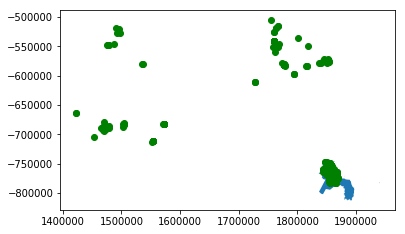

In [419]:
ax=boundary.plot()
dta_power.plot(ax=ax, color='green')

In [420]:
#keep only firms within kampala - maybe define wider boundary later?
dta_power=gpd.sjoin(dta_power, boundary, how='inner')

#knn clustering? 
knn5 = pysal.weights.KNN.from_dataframe(dta_power, k=5, ids='ID')
type(knn5)
knn5[1]

In [424]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Copyright (C) 2016 Paul Brodersen <paulbrodersen+idw@gmail.com>

# Author: Paul Brodersen <paulbrodersen+idw@gmail.com>

# This program is free software; you can redistribute it and/or
# modify it under the terms of the GNU General Public License
# as published by the Free Software Foundation; either version 3
# of the License, or (at your option) any later version.

# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.

# You should have received a copy of the GNU General Public License
# along with this program. If not, see <http://www.gnu.org/licenses/>.

"""
Inverse distance weighting (IDW)
--------------------------------
Compute the score of query points based on the scores of their k-nearest neighbours,
weighted by the inverse of their distances.
Example:
--------
# import idw
# 'train'
idw_tree = idw.tree(X1, z1)
# 'test'
spacing = np.linspace(-5., 5., 100)
X2 = np.meshgrid(spacing, spacing)
grid_shape = X2[0].shape
X2 = np.reshape(X2, (2, -1)).T
z2 = idw_tree(X2)
For a more complete example see demo().
"""

import numpy as np
from scipy.spatial import cKDTree

class tree(object):
    """
    Compute the score of query points based on the scores of their k-nearest neighbours,
    weighted by the inverse of their distances.
    @reference:
    https://en.wikipedia.org/wiki/Inverse_distance_weighting
    Arguments:
    ----------
        X: (N, d) ndarray
            Coordinates of N sample points in a d-dimensional space.
        z: (N,) ndarray
            Corresponding scores.
        leafsize: int (default 10)
            Leafsize of KD-tree data structure;
            should be less than 20.
    Returns:
    --------
        tree instance: object
    Example:
    --------
    # 'train'
    idw_tree = tree(X1, z1)
    # 'test'
    spacing = np.linspace(-5., 5., 100)
    X2 = np.meshgrid(spacing, spacing)
    X2 = np.reshape(X2, (2, -1)).T
    z2 = idw_tree(X2)
    See also:
    ---------
    demo()
    """
    def __init__(self, X=None, z=None, leafsize=10):
        if not X is None:
            self.tree = cKDTree(X, leafsize=leafsize )
        if not z is None:
            self.z = z

    def fit(self, X=None, z=None, leafsize=10):
        """
        Instantiate KDtree for fast query of k-nearest neighbour distances.
        Arguments:
        ----------
            X: (N, d) ndarray
                Coordinates of N sample points in a d-dimensional space.
            z: (N,) ndarray
                Corresponding scores.
            leafsize: int (default 10)
                Leafsize of KD-tree data structure;
                should be less than 20.
        Returns:
        --------
            idw_tree instance: object
        Notes:
        -------
        Wrapper around __init__().
        """
        return self.__init__(X, z, leafsize)

    def __call__(self, X, k=20, eps=1e-6, p=2, regularize_by=1e-9):
        """
        Compute the score of query points based on the scores of their k-nearest neighbours,
        weighted by the inverse of their distances.
        Arguments:
        ----------
            X: (N, d) ndarray
                Coordinates of N query points in a d-dimensional space.
            k: int (default 6)
                Number of nearest neighbours to use.
            p: int or inf
                Which Minkowski p-norm to use.
                1 is the sum-of-absolute-values "Manhattan" distance
                2 is the usual Euclidean distance
                infinity is the maximum-coordinate-difference distance
            eps: float (default 1e-6)
                Return approximate nearest neighbors; the k-th returned value
                is guaranteed to be no further than (1+eps) times the
                distance to the real k-th nearest neighbor.
            regularise_by: float (default 1e-9)
                Regularise distances to prevent division by zero
                for sample points with the same location as query points.
        Returns:
        --------
            z: (N,) ndarray
                Corresponding scores.
        """
        self.distances, self.idx = self.tree.query(X, k, eps=eps, p=p)
        self.distances += regularize_by
        weights = self.z[self.idx.ravel()].reshape(self.idx.shape)
        mw = np.sum(weights/self.distances, axis=1) / np.sum(1./self.distances, axis=1)
        return mw

    def transform(self, X, k=20, p=2, eps=1e-6, regularize_by=1e-9):
        """
        Compute the score of query points based on the scores of their k-nearest neighbours,
        weighted by the inverse of their distances.
        Arguments:
        ----------
            X: (N, d) ndarray
                Coordinates of N query points in a d-dimensional space.
            k: int (default 6)
                Number of nearest neighbours to use.
            p: int or inf
                Which Minkowski p-norm to use.
                1 is the sum-of-absolute-values "Manhattan" distance
                2 is the usual Euclidean distance
                infinity is the maximum-coordinate-difference distance
            eps: float (default 1e-6)
                Return approximate nearest neighbors; the k-th returned value
                is guaranteed to be no further than (1+eps) times the
                distance to the real k-th nearest neighbor.
            regularise_by: float (default 1e-9)
                Regularise distances to prevent division by zero
                for sample points with the same location as query points.
        Returns:
        --------
            z: (N,) ndarray
                Corresponding scores.
        Notes:
        ------
        Wrapper around __call__().
        """
        return self.__call__(X, k, eps, p, regularize_by)

def demo():
    import matplotlib.pyplot as plt

    # create sample points with structured scores
    X1 = 10 * np.random.rand(1000, 2) -5

    def func(x, y):
        return np.sin(x**2 + y**2) / (x**2 + y**2)

    z1 = func(X1[:,0], X1[:,1])

    # 'train'
    idw_tree = tree(X1, z1)

    # 'test'
    spacing = np.linspace(-5., 5., 100)
    X2 = np.meshgrid(spacing, spacing)
    grid_shape = X2[0].shape
    X2 = np.reshape(X2, (2, -1)).T
    z2 = idw_tree(X2)

    # plot
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharex=True, sharey=True, figsize=(10,3))
    ax1.contourf(spacing, spacing, func(*np.meshgrid(spacing, spacing)))
    ax1.set_title('Ground truth')
    ax2.scatter(X1[:,0], X1[:,1], c=z1, linewidths=0)
    ax2.set_title('Samples')
    ax3.contourf(spacing, spacing, z2.reshape(grid_shape))
    ax3.set_title('Reconstruction')
    plt.show()
return

In [426]:
#create grid over the city
from shapely.geometry import Polygon
xmin,ymin,xmax,ymax = dta_power.total_bounds
length = 100
width = 100
ymax=ymax+length
cols = list(range(int(np.floor(xmin)), int(np.ceil(xmax)), width))
rows = list(range(int(np.floor(ymin)), int(np.ceil(ymax)), length))
rows.reverse()

polygons = []
for x in cols:
    for y in rows:
        polygons.append( Polygon([(x,y), (x+width, y), (x+width, y-length), (x, y-length)]) )

grid = gpd.GeoDataFrame({'geometry':polygons})
#grid.to_file("grid.shp")

In [427]:
grid['centroid']=grid.centroid
grid['old_geometry']=grid.geometry
grid=grid.set_geometry(grid['centroid'])
grid['X']=grid.geometry.x
grid['Y']=grid.geometry.y
grid.head()

,geometry,centroid,old_geometry,X,Y
0,POINT (1843133 -749529),POINT (1843133 -749529),"POLYGON ((1843083 -749479, 1843183 -749479, 18...",1843133.0,-749529.0
1,POINT (1843133 -749629),POINT (1843133 -749629),"POLYGON ((1843083 -749579, 1843183 -749579, 18...",1843133.0,-749629.0
2,POINT (1843133 -749729),POINT (1843133 -749729),"POLYGON ((1843083 -749679, 1843183 -749679, 18...",1843133.0,-749729.0
3,POINT (1843133 -749829),POINT (1843133 -749829),"POLYGON ((1843083 -749779, 1843183 -749779, 18...",1843133.0,-749829.0
4,POINT (1843133 -749929),POINT (1843133 -749929),"POLYGON ((1843083 -749879, 1843183 -749879, 18...",1843133.0,-749929.0


In [425]:
dta_power['X']=dta_power.geometry.x
dta_power['Y']=dta_power.geometry.y
dta_power.head()

,geometry,powout_rain,powout_norain,ID,index_right,place_name,X,Y
0,POINT (1859759.719282152 -768151.0548521631),12.0,5.0,0,0,"Dar es Salaam, Coastal Zone, Tanzania",1.859760e+06,-768151.054852
1,POINT (1861336.871739428 -764555.4117875871),48.0,2.0,1,0,"Dar es Salaam, Coastal Zone, Tanzania",1.861337e+06,-764555.411788
2,POINT (1865435.000523455 -776114.5067795911),NaN,NaN,2,0,"Dar es Salaam, Coastal Zone, Tanzania",1.865435e+06,-776114.506780
3,POINT (1864482.527666895 -776364.3189905487),NaN,NaN,3,0,"Dar es Salaam, Coastal Zone, Tanzania",1.864483e+06,-776364.318991
4,POINT (1864541.192135317 -777094.5570852804),192.0,12.0,4,0,"Dar es Salaam, Coastal Zone, Tanzania",1.864541e+06,-777094.557085


In [448]:
#get coordinates from firms, outage values, and grid coordinates as arrays
coordinates_grid=grid[['X', 'Y']].values
dta_power_analysis=dta_power[pd.notnull(dta_power['powout_rain'])]
dta_power_analysis=dta_power_analysis[dta_power_analysis['powout_rain']<730]
coordinates=dta_power_analysis[['X', 'Y']].values
values=dta_power_analysis[['powout_rain']].values

In [449]:
len(values)

558

In [454]:
#try other interpolation methods - why do linear and cubic mostly return nan?? 
from scipy.interpolate import griddata
grid_z0 = griddata(coordinates, values, coordinates_grid, method='nearest')
grid_z1 = griddata(coordinates, values, coordinates_grid, method='linear')
grid_z2 = griddata(coordinates, values, coordinates_grid, method='cubic')
grid['nearest']=grid_z0
grid['linear']=grid_z1
grid['cubic']=grid_z2

In [455]:
grid=grid.set_geometry(grid.old_geometry)
grid.head()

,geometry,centroid,old_geometry,X,Y,nearest,linear,cubic,idw
0,"POLYGON ((1843083 -749479, 1843183 -749479, 18...",POINT (1843133 -749529),"POLYGON ((1843083 -749479, 1843183 -749479, 18...",1843133.0,-749529.0,15.0,NaN,NaN,30.739041
1,"POLYGON ((1843083 -749579, 1843183 -749579, 18...",POINT (1843133 -749629),"POLYGON ((1843083 -749579, 1843183 -749579, 18...",1843133.0,-749629.0,15.0,NaN,NaN,30.729160
2,"POLYGON ((1843083 -749679, 1843183 -749679, 18...",POINT (1843133 -749729),"POLYGON ((1843083 -749679, 1843183 -749679, 18...",1843133.0,-749729.0,15.0,NaN,NaN,30.719522
3,"POLYGON ((1843083 -749779, 1843183 -749779, 18...",POINT (1843133 -749829),"POLYGON ((1843083 -749779, 1843183 -749779, 18...",1843133.0,-749829.0,15.0,NaN,NaN,30.710142
4,"POLYGON ((1843083 -749879, 1843183 -749879, 18...",POINT (1843133 -749929),"POLYGON ((1843083 -749879, 1843183 -749879, 18...",1843133.0,-749929.0,15.0,NaN,NaN,30.701035


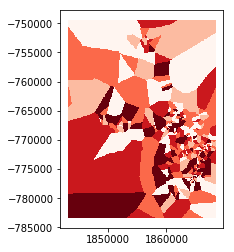

In [457]:
#plot nearest neighbor weighting #cubism
ax=grid.plot(cmap='Reds', column='nearest', scheme='Quantiles')

In [458]:
#inverse distance weighting
idw_tree = tree(coordinates, values)
z2=idw_tree(coordinates_grid)
grid['idw']=z2
grid.head()

,geometry,centroid,old_geometry,X,Y,nearest,linear,cubic,idw
0,"POLYGON ((1843083 -749479, 1843183 -749479, 18...",POINT (1843133 -749529),"POLYGON ((1843083 -749479, 1843183 -749479, 18...",1843133.0,-749529.0,15.0,NaN,NaN,30.739041
1,"POLYGON ((1843083 -749579, 1843183 -749579, 18...",POINT (1843133 -749629),"POLYGON ((1843083 -749579, 1843183 -749579, 18...",1843133.0,-749629.0,15.0,NaN,NaN,30.729160
2,"POLYGON ((1843083 -749679, 1843183 -749679, 18...",POINT (1843133 -749729),"POLYGON ((1843083 -749679, 1843183 -749679, 18...",1843133.0,-749729.0,15.0,NaN,NaN,30.719522
3,"POLYGON ((1843083 -749779, 1843183 -749779, 18...",POINT (1843133 -749829),"POLYGON ((1843083 -749779, 1843183 -749779, 18...",1843133.0,-749829.0,15.0,NaN,NaN,30.710142
4,"POLYGON ((1843083 -749879, 1843183 -749879, 18...",POINT (1843133 -749929),"POLYGON ((1843083 -749879, 1843183 -749879, 18...",1843133.0,-749929.0,15.0,NaN,NaN,30.701035


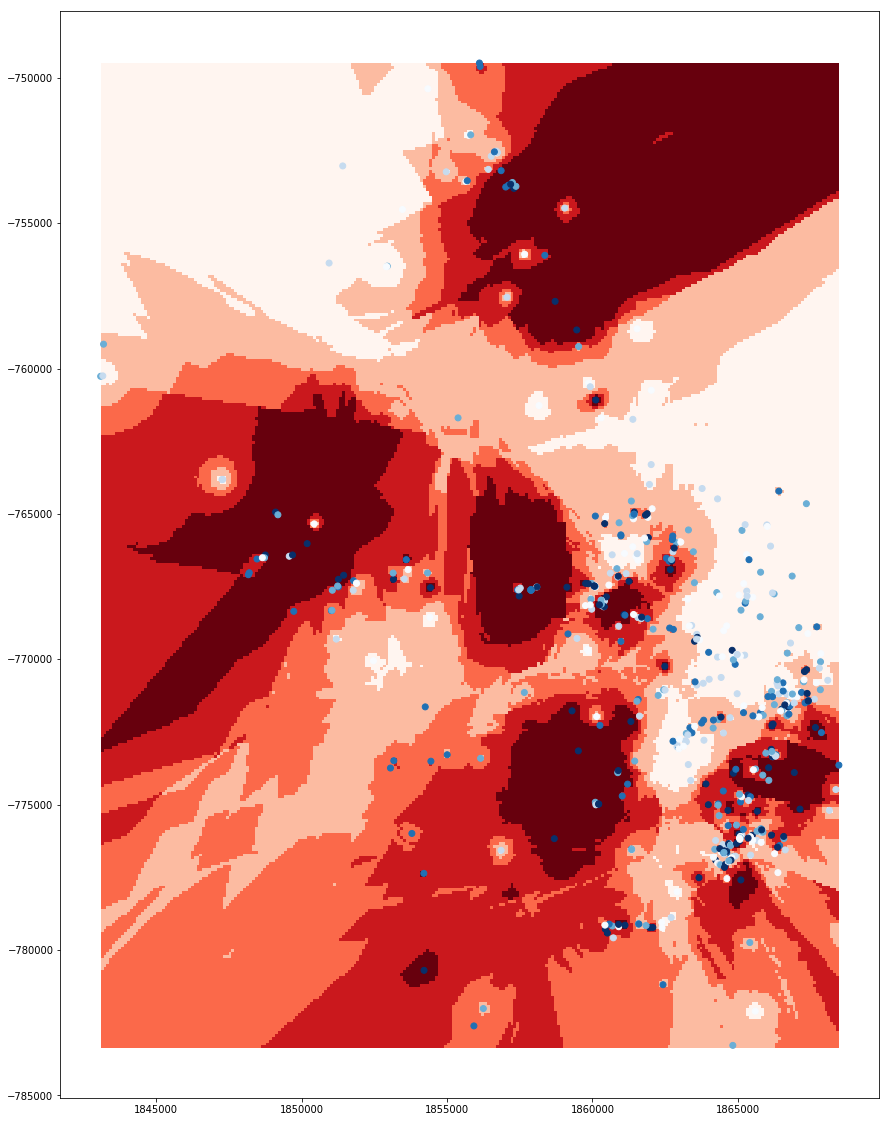

In [459]:
#plot inverse distance weighting
ax=grid.plot(cmap='Reds', column='idw', figsize=(20,20), scheme='Quantiles')
dta_power_analysis.plot(ax=ax, cmap='Blues', column='powout_rain', scheme='Quantiles')


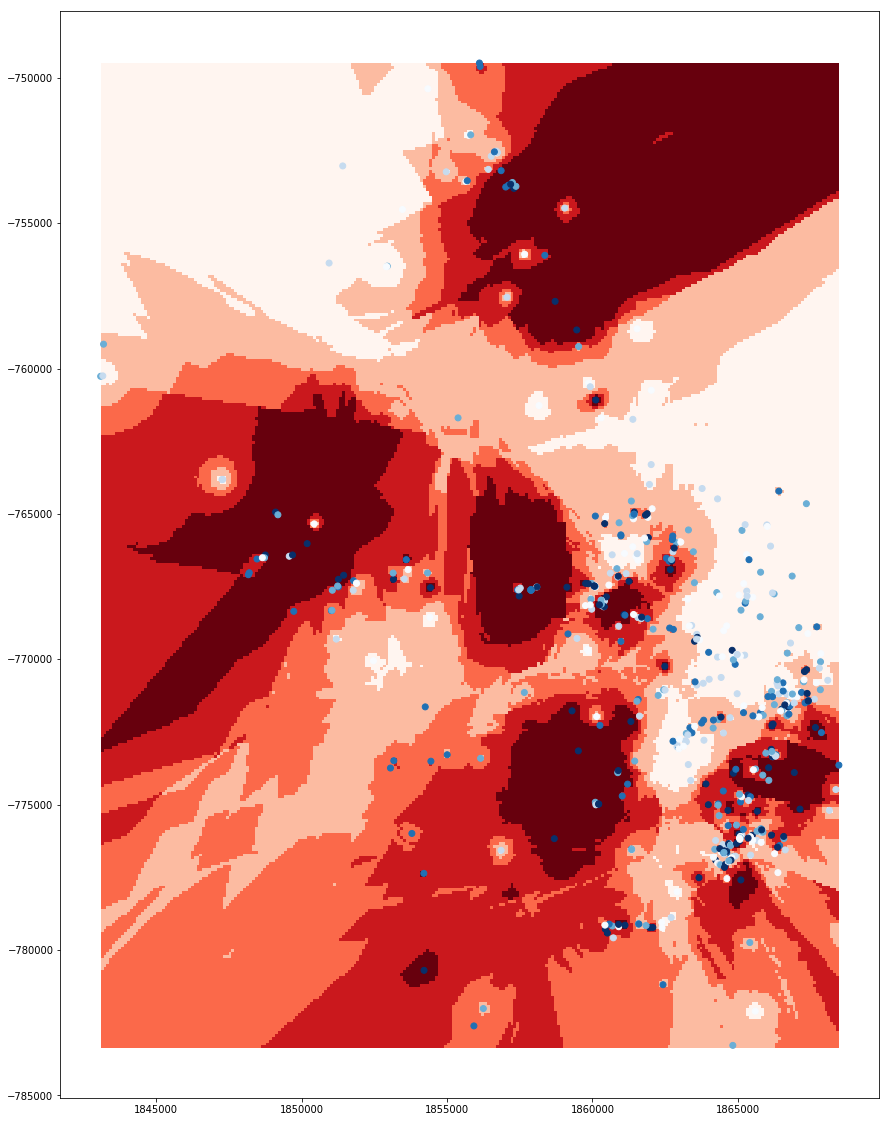

In [460]:
boundary['boundarygeometry']= boundary.boundary
boundary = boundary.set_geometry('boundarygeometry')
ax=grid.plot(cmap='Reds', column='idw', figsize=(20,20), scheme='Quantiles')
dta_power_analysis.plot(ax=ax, cmap='Blues', column='powout_rain', scheme='Quantiles')
boundary.plot(ax=ax)

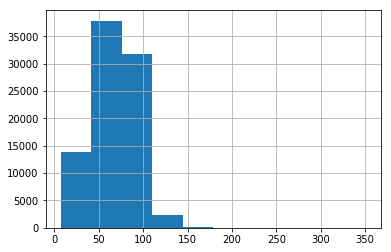

In [461]:
grid.idw.hist()

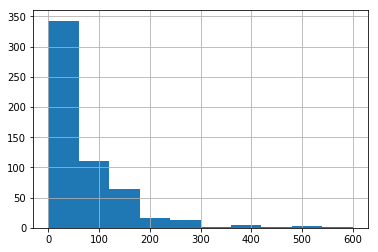

In [462]:
dta_power_analysis.powout_rain.hist()